# Short Introduction to Neural Networks and Deep Learning with Pytorch

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose

In [3]:
%matplotlib widget

# How to define a Neural Network Architecture in Torch

To declare a new Network architecture, we create a new class inheriting from `torch.nn.Model`.

The simplest way to declare a Network architecture is to declare the sequence of layers using `torch.nn.Sequential`
in `__init__` and we have to implement the `forward` pass. The rest is taken care of by torch (gradients, backword propagation, ...) automagically.

Torch builds a computational graph, that can be executed (on different devices) and transformed (e.g. calculate the gradient).

In [4]:
class FullyConnected(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(8 * 8 * 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        # x.shape = (batchsize, 1, 8, 8)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [5]:
FullyConnected()

FullyConnected(
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

Now we are building a more flexible model, were we can pass some options:

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, input_size, n_classes, dropout=0.25, n_hidden=256):
        super().__init__()
        self.flatten = nn.Flatten()
        
        self.fc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size),
            # First Hidden Layer
            nn.Linear(input_size, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.Dropout(dropout),
            nn.LeakyReLU(),

            
            # Second Hidden Layer
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.Dropout(dropout),
            nn.LeakyReLU(),
            
            # Output Layer
            nn.Linear(n_hidden, n_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc_stack(x)
        return x
    
FullyConnected(input_size=3 * 50 * 50, n_classes=2)

FullyConnected(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_stack): Sequential(
    (0): BatchNorm1d(7500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=7500, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=256, out_features=2, bias=True)
    (10): Softmax(dim=1)
  )
)

# Training

Unfortunately, training the network is not as simple as calling `fit` like in sklearn.
Torch is a very flexible framework, and we have to decide for the data loader, loss function, the optimizer, the model, device and how we evaluate the performance on the test data set.

In the end, we are going to write our own `fit` function, to make it simpler.

In [7]:
# device = "cpu"
# uncomment to use GPU if available
# CPU offers better debugging
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(DEVICE))

Using cpu device


In [8]:
def train(dataloader, model, loss_fn, optimizer, device=DEVICE):    
    model = model.to(device)
    model.train()
    
    losses = []
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
               
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
       
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # store loss for plotting
        losses.append(loss.item())
    return losses

            
def test(dataloader, model, loss_fn, device=DEVICE):
    model = model.to(device)
    test_losses = []
    with torch.no_grad():
        model.eval()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_losses.append(loss_fn(pred, y).item())

    return test_losses


def fit_one_epoch(train_dataloader, test_dataloader, model, loss_fn, optimizer, device=DEVICE):
    train_losses = train(train_dataloader, model, loss_fn, optimizer, device)
    test_losses = test(test_dataloader, model, loss_fn, device)
    return train_losses, test_losses


def accuracy(dataloader, model, device=DEVICE):
    correct = 0
    total = 0
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total += len(y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return correct / total


def predictions(dataloader, model, device=DEVICE):
    predictions = []
    truth = []
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            predictions.append(model(X).argmax(1))
            truth.append(y)
    return torch.cat(predictions), torch.cat(truth)


def report_accuracy(test_dataloader, train_dataloader, model):
    accuracy_test = accuracy(test_dataloader, model)
    accuracy_train = accuracy(train_dataloader, model)
    print(f'Accuracy: train={accuracy_train:5.1%}, test={accuracy_test:5.1%}')

# MNIST

In [9]:
mnist_train = datasets.MNIST(
    root="data",
    train=True,
    transform=Compose([Resize((16, 16)), ToTensor()]),
    download=True,
)

mnist_test = datasets.MNIST(
    root="data",
    train=False,
    transform=Compose([Resize((16, 16)), ToTensor()]),
    download=True,

)

100%|██████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 16413060.92it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 42533600.36it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 8452836.92it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 3117415.93it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [10]:
batch_size = 64

train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)


# get first batch
X, y = next(iter(test_dataloader))

print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  torch.Size([64, 1, 16, 16])
Shape of y:  torch.Size([64])


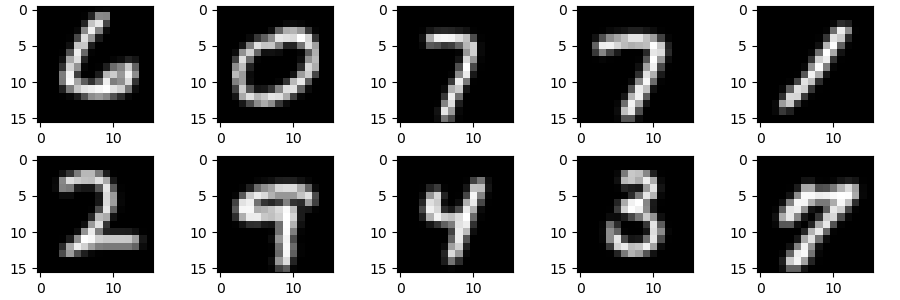

In [11]:
fig, axs = plt.subplots(2, 5, figsize=(9, 3), constrained_layout=True)

for i, ax in enumerate(axs.flat):
    ax.imshow(X[i, 0], cmap='gray')

In [ ]:
model = FullyConnected(
    input_size=X[0].shape.numel(),
    n_classes=len(mnist_train.classes),
    n_hidden=256,
    dropout=0.25,
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())


epochs = 20
test_losses = []
train_losses = []
report_accuracy(test_dataloader, train_dataloader, model)
for t in tqdm(range(epochs)):
    epoch_loss_train, epoch_loss_test = fit_one_epoch(
        train_dataloader, test_dataloader, model, loss_fn, optimizer
    )
    train_losses.append(epoch_loss_train)
    test_losses.append(epoch_loss_test)
    report_accuracy(test_dataloader, train_dataloader, model)
    
print("Done!")

In [ ]:
def plot_losses(train_losses, test_losses):
    plt.figure()
    
    for i, (label, losses) in enumerate(zip(("Train", "Test"), (train_losses, test_losses))):
        losses = np.array(losses)
       
        x = np.linspace(0, len(losses), losses.size)
        plt.plot(x, losses.ravel(), label=f'Loss {label}', color=f'C{i}', alpha=0.5)
                
        mean_loss = losses.mean(axis=1)
        x = np.arange(0.5, len(mean_loss))
        plt.plot(x, mean_loss, label=f'Mean Epoch Loss {label}', color=f'C{i}', zorder=3)
        
    plt.xlabel('Epoch')
    plt.legend()

In [ ]:
plot_losses(train_losses, test_losses)
plt.yscale('log')

# CIFAR-10

In [ ]:
cifar10_train = datasets.CIFAR10(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)

cifar10_test = datasets.CIFAR10(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True,
)

In [ ]:
batch_size = 64

train_dataloader = DataLoader(cifar10_train, batch_size=batch_size)
test_dataloader = DataLoader(cifar10_test, batch_size=batch_size)

# get first batch
X, y = next(iter(test_dataloader))

print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(9, 9), constrained_layout=True)

for idx, ax in enumerate(axs.flat):
    img = np.swapaxes(X[idx + 16], 1, 2).T
    

    ax.set_title(cifar10_train.classes[y[idx + 16]])
    ax.imshow(img)
    ax.set_axis_off()

In [ ]:
model = FullyConnected(
    input_size=X[0].shape.numel(),
    n_classes=len(cifar10_train.classes),
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


test_losses = []
train_losses = []


report_accuracy(test_dataloader, train_dataloader, model)

epochs = 15
for t in tqdm(range(epochs)):
    epoch_loss_train, epoch_loss_test = fit_one_epoch(
        train_dataloader, test_dataloader, model, loss_fn, optimizer
    )
    train_losses.append(epoch_loss_train)
    test_losses.append(epoch_loss_test)
    report_accuracy(test_dataloader, train_dataloader, model)
    
print("Done!")

In [ ]:
plot_losses(train_losses, test_losses)
plt.yscale('log')

We do not get much better than 50 % with a fully connected network.

Let's try a deep learning network with convolutional layers. The architecture follows the one proposed here:
https://arxiv.org/abs/1409.1556

> Very Deep Convolutional Networks for Large-Scale Image Recognition  
> Karen Simonyan, Andrew Zisserman

> In this work we investigate the effect of the convolutional network depth on its accuracy in the large-scale image recognition setting. Our main contribution is a thorough evaluation of networks of increasing depth using an architecture with very small (3x3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16-19 weight layers. These findings were the basis of our ImageNet Challenge 2014 submission, where our team secured the first and the second places in the localisation and classification tracks respectively. We also show that our representations generalise well to other datasets, where they achieve state-of-the-art results. We have made our two best-performing ConvNet models publicly available to facilitate further research on the use of deep visual representations in computer vision. 

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_stack = nn.Sequential(
            # 1st stack of conv layers
            nn.Conv2d(3, 32, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding='same'),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            # 2nd stack
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same'),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            # 3rd stack
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding='same'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
        )
        
        self.flatten = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128),
            nn.Dropout(0.25),
            nn.LeakyReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [ ]:
model = ConvolutionalNetwork()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

test_losses = []
train_losses = []

In [ ]:
epochs = 25


report_accuracy(test_dataloader, train_dataloader, model)

for t in tqdm(range(epochs)):
    epoch_loss_train, epoch_loss_test = fit_one_epoch(
        train_dataloader, test_dataloader, model, loss_fn, optimizer
    )
    train_losses.append(epoch_loss_train)
    test_losses.append(epoch_loss_test)
    report_accuracy(test_dataloader, train_dataloader, model)
    
print("Done!")

In [ ]:
plot_losses(train_losses=train_losses, test_losses=test_losses)

In [ ]:
prediction, y = predictions(test_dataloader, model)

In [ ]:
from sklearn.metrics import confusion_matrix


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

matrix = confusion_matrix(y.cpu().numpy(), prediction.cpu().numpy())
matrix = np.divide(matrix, matrix.sum(axis = 1))

plt.matshow(matrix)
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
plt.colorbar()
None